# Relacion de Flujos

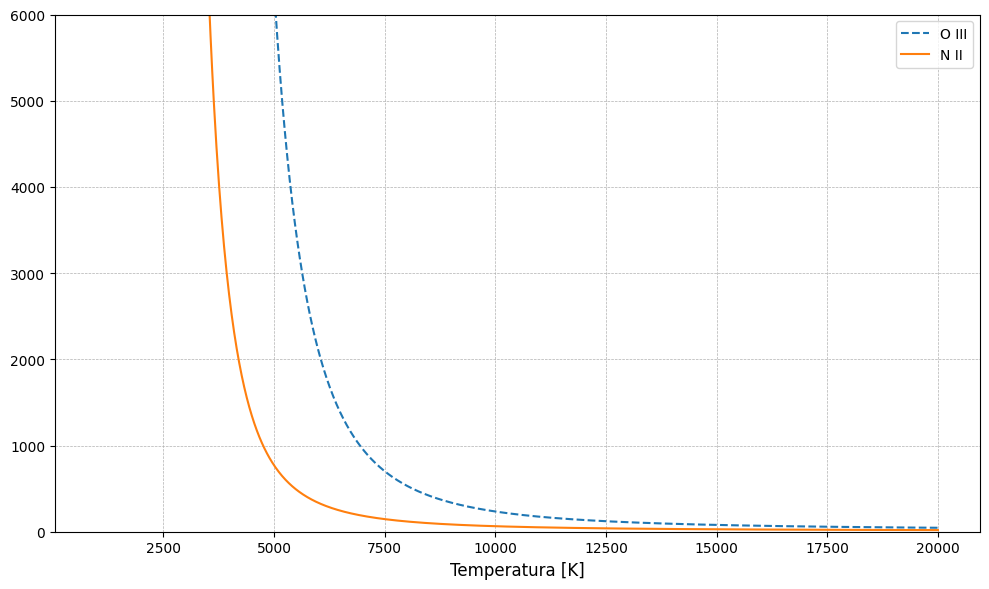

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Densidad electrónica fija
Ne = 1e-4  # por ejemplo 10^4 cm^-3

# Función para coeficiente de emisión O III
def coef_OIII(Ne, T):
    term_exp = np.exp(32985 / T)
    sqrt_T = np.sqrt(T)
    numerator = (Ne / sqrt_T) + 2.6e5 * (1 + 0.12 * np.exp(-32985 / T))
    denominator = (Ne / sqrt_T) + 1627
    return 0.054 * term_exp * (numerator / denominator)


# Función para coeficiente de emisión N II
def coef_NII(Ne, T):
    term_exp = np.exp(25007 / T)
    sqrt_T = np.sqrt(T)
    numerator = (Ne / sqrt_T) + 1.3e5 * (1 + 0.12 * np.exp(-25007 / T))
    denominator = (Ne / sqrt_T) + 250.4
    return 0.01 * term_exp * (numerator / denominator)


# Rango de temperaturas
temperatura = np.linspace(1000, 20000, 1000)
#temperatura = np.logspace(1000, 20000, 500)  # desde 1000 K hasta 20000 K

# Calcular emisividades para todo el rango de T
emisividad_OIII = coef_OIII(Ne, temperatura)
emisividad_NII = coef_NII(Ne, temperatura)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(temperatura, emisividad_OIII, "--", label="O III")
plt.plot(temperatura, emisividad_NII, "-", label="N II")
#plt.xscale("log")
plt.ylim(0, 6000)  # Ajustar el límite del eje y

plt.xlabel("Temperatura [K]", fontsize=12)
#plt.ylabel("Coef. de emisión (unidades arbitrarias)", fontsize=12)
#plt.title(f"Coef. de emisión para $N_e = {Ne:.1e}$ cm$^{{-3}}$", fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

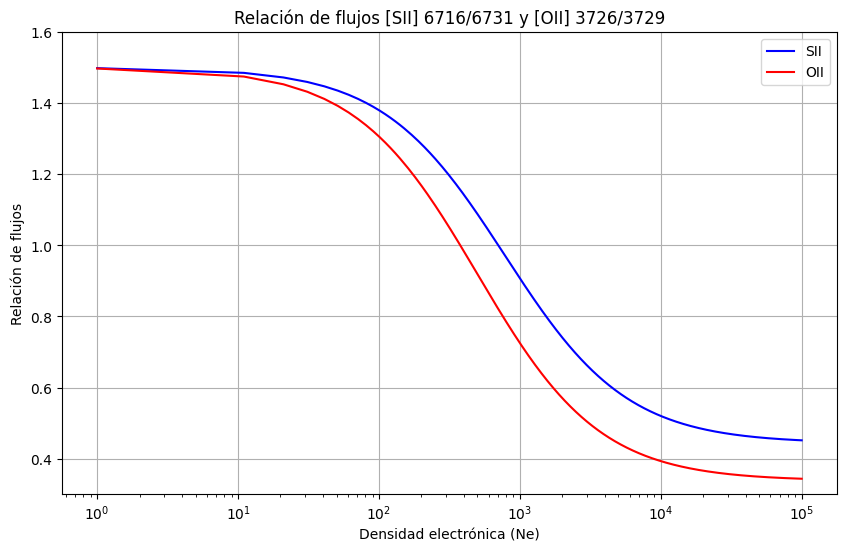

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Densidad electrónica fija
Ratio_flux = 1.2  # Relación de flujos [O II] 3726/3729

A6716 = 2.6e-4
A6731 = 8.8e-4


# Función para coeficiente de emisión O III
def Constante_Ne(Ra, A6716, A6731):
    numerator = 0.26 * ((2 / 3) * Ra * (A6716**2 / A6731) - A6731)
    denominator = 8.63e-6*(1-((2/3)*Ra*(A6716/A6731)))
    return (numerator / denominator)


Ne = 1e-4  # por ejemplo 10^4 cm^-3
# rango de Ne
Ne = np.linspace(1, 100000, 10000)
Temperature = 10000  # Temperatura en Kelvin
C = 8.63e-6 / np.sqrt(Temperature)  # Constante de densidad electrónica

ratio_SII = f6716_over_f6731(Ne, C)
ratio_OII = f3726_over_f3729(Ne, C)
# Graficar la relación de flujos
plt.figure(figsize=(10, 6))
plt.plot(Ne, ratio_SII, label="SII", color="blue")
plt.plot(Ne, ratio_OII, label="OII", color="red")
plt.title("Relación de flujos [SII] 6716/6731 y [OII] 3726/3729")
plt.xlabel("Densidad electrónica (Ne)")
plt.ylabel("Relación de flujos")
plt.xscale("log")
# plt.yscale('log')
plt.ylim(0.3, 1.6)
# plt.xlim()
plt.legend()
plt.grid()
plt.show()

In [14]:
# Densidad electrónica fija
Ratio_flux = 1.2  # Relación de flujos [O II] 3726/3729
Ne = 1e-4  # por ejemplo 10^4 cm^-3
A6716 = 2.6e-4
A6731 = 8.8e-4


# Función para coeficiente de emisión O III
def Constante_Ne(Ra, A6716, A6731):
    numerator = 0.26 * ((2 / 3) * Ra * (A6716**2 / A6731) - A6731)
    denominator = 8.63e-3
    return 0.054 * term_exp * (numerator / denominator)

## Exportacion SQL

In [15]:
# Exportar datos con código SQL de SQL Server (ejemplo para SDSS)
import pandas as pd
from astroquery.sdss import SDSS

# SQL multi-line string debe estar correctamente delimitado
q1 = """
SELECT TOP 10000
    s.plate,s.class, s.fiberid, s.mjd, s.z as redshift,
    s.ra, s.dec,s.bestobjid AS sdss_name,
    g.h_beta_flux, g.h_alpha_flux,
    g.oiii_4363_flux,
    g.oiii_4959_flux,
    g.oiii_5007_flux,
    g.sii_6717_flux,
    g.sii_6731_flux,
    g.nii_6548_flux,
    g.nii_6584_flux
FROM GalSpecLine AS g
JOIN SpecObj AS s
    ON s.specobjid = g.specobjid
WHERE
    (s.class = 'GALAXY' OR s.class = 'QSO')
    ANd g.oiii_4363_flux > 0
    AND g.oiii_4959_flux > 0
    AND g.oiii_5007_flux > 0
    AND g.sii_6717_flux > 0
    AND g.sii_6731_flux > 0
    AND g.nii_6548_flux > 0
    ORDER BY s.plate, s.fiberid
"""

query = q1

results = SDSS.query_sql(query)
df = results.to_pandas()
print(df.head())

   plate   class  fiberid    mjd  redshift         ra       dec  \
0    266  GALAXY        1  51630  0.021222  146.71421 -1.041304   
1    266  GALAXY        4  51630  0.064656  146.62857 -0.765137   
2    266  GALAXY       12  51630  0.055981  146.96390 -0.545003   
3    266  GALAXY       13  51630  0.097086  146.96350 -0.759352   
4    266  GALAXY       14  51630  0.064779  146.94999 -0.592202   

             sdss_name  h_beta_flux  h_alpha_flux  oiii_4363_flux  \
0  1237648720142401611   119.495600     472.59040       14.544610   
1  1237650795146445031    25.640470      99.40005        0.903860   
2                    0    42.869560     195.51970        3.899584   
3  1237650795146641532     3.303172      21.55664        4.435488   
4                    0    60.806910     229.13250        1.974468   

   oiii_4959_flux  oiii_5007_flux  sii_6717_flux  sii_6731_flux  \
0       24.923760        68.39606      124.71150      84.180530   
1        9.876856        21.44437       35.33497

In [16]:
# contar las clases de objetos en Galaxias y QSOs
counts = df['class'].value_counts()
print(counts)

class
GALAXY    9658
QSO        342
Name: count, dtype: int64


In [17]:
# seleccionar los objetos del 1000 al 1990
df_eduardo = df.iloc[1000:1990]
cont = df_eduardo['class'].value_counts()
print(cont)


class
GALAXY    955
QSO        35
Name: count, dtype: int64


In [18]:
# calcular la relación de líneas de emisión
df_eduardo['oiii_ratio'] = (df_eduardo['oiii_4959_flux'] + df_eduardo['oiii_5007_flux']) / df_eduardo['oiii_4363_flux']
print(df_eduardo)


      plate   class  fiberid    mjd  redshift         ra       dec  \
1000    272  GALAXY      236  51941  0.078457  155.70486 -0.620604   
1001    272  GALAXY      237  51941  0.094887  155.82748 -0.429315   
1002    272  GALAXY      238  51941  0.112738  155.79575 -0.469677   
1003    272  GALAXY      245  51941  0.096060  155.26885 -1.088460   
1004    272  GALAXY      246  51941  0.087625  155.51461 -1.089007   
...     ...     ...      ...    ...       ...        ...       ...   
1985    278  GALAXY       60  51900  0.100052  167.68517 -0.809645   
1986    278  GALAXY       61  51900  0.054632  168.36150 -0.533847   
1987    278  GALAXY       62  51900  0.090442  168.32126 -0.090308   
1988    278  GALAXY       66  51900  0.040137  168.31290 -0.182935   
1989    278  GALAXY       78  51900  0.124125  168.21871 -0.192003   

                sdss_name  h_beta_flux  h_alpha_flux  oiii_4363_flux  \
1000  1237648720683204778     7.776472      15.42925        5.075505   
1001  123764872

C:\Users\eduar\AppData\Local\Temp\ipykernel_32356\3323227566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eduardo['oiii_ratio'] = (df_eduardo['oiii_4959_flux'] + df_eduardo['oiii_5007_flux']) / df_eduardo['oiii_4363_flux']
